In [0]:
# Identifying superclasses indexes
# Identifying superclasses indexes
import pandas as pd
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded1 = drive.CreateFile({'id':'1IfioWuWPLvvMvkdVCflMh5v6xVfKwBxW'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('meta')

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
meta = unpickle('meta')
k=0
# Looping through the list to find the index of vehicle 1 and vehicle 2
for i in meta[b'coarse_label_names']:
  if i==b'vehicles_1':
    a = k
  if i==b'vehicles_2':
    b = k
  k=k+1  
print('Vehicle 1 index:',a,'\nVehicle 2 index:',b)
coarse = pd.DataFrame(meta[b'coarse_label_names'])
fine = pd.DataFrame(meta[b'fine_label_names'])

Vehicle 1 index: 18 
Vehicle 2 index: 19


## With Cifar-100 dataset in Keras

In [0]:
# install keras first
!pip install dill
!pip install -q keras

In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32,TF_CPP_MIN_LOG_LEVEL=2"

In [0]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.tensorflow_backend.set_image_dim_ordering("th")

Using TensorFlow backend.


In [0]:
#batch_size = 1000
num_classes = 2
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar100'
'''

'\nepochs_longrun = 500\nsave_dir = "/work"\nres_dir = "/results"\nmodel_name = \'convnet_cifar100\'\n'

In [0]:
from keras.datasets import cifar100

In [0]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [0]:
def combinedf(x,y,z):
  # Required subset of data in dataframe
  x = x.reshape(x.shape[0],3*32*32)
  images_df = pd.DataFrame(x, columns = list(range(0,3072)))
  temp = pd.DataFrame(y, columns = ['Target'])
  sub = pd.DataFrame(z, columns = ['Subtar'])
  images_df = pd.concat([images_df,sub,temp],axis=1)
  vehicle_images = images_df[(images_df['Target']==18) | (images_df['Target']==19) ]
  vehicle_images['Subtar'] = fine[0][vehicle_images['Subtar']].values # Subtar holds the subclass values.
  vehicle_images['Target'] = coarse[0][vehicle_images['Target']].values # Taget holds the superclass values
  #vehicle_images.head()
  return vehicle_images

In [0]:
import tensorflow as tf
import numpy as np
from keras.utils import to_categorical
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')
(a_train, b_train), (a_test, b_test) = cifar100.load_data(label_mode='fine')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
trainset = combinedf(x_train,y_train,b_train)
testset  = combinedf(x_test,y_test,b_test)

169009152/169001437 [==============================] - 6s 0us/step
x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [0]:
data = pd.concat([trainset,testset],axis=0)

In [0]:
vehicle1 = np.unique(data[(data['Target']==b'vehicles_1')]['Subtar'])
vehicle1

array([b'bicycle', b'bus', b'motorcycle', b'pickup_truck', b'train'],
      dtype=object)

In [0]:
vehicle2 = np.unique(data[(data['Target']==b'vehicles_2')]['Subtar'])
vehicle2

array([b'lawn_mower', b'rocket', b'streetcar', b'tank', b'tractor'],
      dtype=object)

In [0]:
v1s1 = b'motorcycle'
v2s2 = b'lawn_mower'
#v1s3 = b'pickup_truck'
#v2s4 = b'streetcar'

In [0]:
trainset = data[( (data['Subtar']!=v1s1) & (data['Subtar']!=v2s2))] 
testset = data[( (data['Subtar']==v1s1) | (data['Subtar']==v2s2))]

In [0]:
trainset.shape

(4800, 3074)

In [0]:
data[( (data['Subtar']!=v1s1) & (data['Subtar']!=v2s2))].shape

(4800, 3074)

In [0]:
X_train = trainset.drop(['Subtar','Target'],axis=1)
y_train = trainset['Target']
X_test = testset.drop(['Subtar','Target'],axis=1)
y_test = testset['Target']

In [0]:
# #Normalize data
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_train /= 255.0
# X_test /= 255.0

In [0]:
y_train = pd.get_dummies(y_train,drop_first=True)
y_test = pd.get_dummies(y_test,drop_first=True)

In [0]:
X_train.shape

(4800, 3072)

## Random Forest

# Looping

In [0]:
 # Function for preparing the dataset
  def dataprep(v1s1,v2s2):
    trainset = data[( (data['Subtar']!=v1s1) & (data['Subtar']!=v2s2))] 
    testset = data[( (data['Subtar']==v1s1) | (data['Subtar']==v2s2))]
    X_train = trainset.drop(['Subtar','Target'],axis=1)
    y_train = trainset['Target']
    X_test = testset.drop(['Subtar','Target'],axis=1)
    y_test = testset['Target']
    #Normalize data
    # X_train = X_train.astype('float32')
    # X_test = X_test.astype('float32')
    # X_train /= 255.0
    # X_test /= 255.0
    y_train = pd.get_dummies(y_train,drop_first=True)
    y_test = pd.get_dummies(y_test,drop_first=True)
    return X_train,X_test,y_train,y_test

In [0]:
# To avoid warnings in the output.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
# To avoid warnings in the output.
def warn(*args, **kwargs):
  pass
import warnings
warnings.warn = warn

In [0]:
# Generating all 25 combinations and looping through each combination and calling RandomForest object each time :

from itertools import combinations 
import pickle
from sklearn.ensemble import RandomForestClassifier
a = []
b = []
c = []

a=vehicle1
b=vehicle2    
print(a)
print(b)

import time 
H=[]
maxscore = -1
for k in a:
    for l in b:
      v1s1 = k
      v2s2 = l
      os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
      tf.logging.set_verbosity(tf.logging.ERROR)
      X_train,X_test,y_train,y_test = dataprep(v1s1,v2s2)
      X_train = X_train.values
      X_test = X_test.values
      X_train = X_train.reshape(X_train.shape[0],3*32*32)
      X_test = X_test.reshape(X_test.shape[0],3*32*32)
      from keras.utils import np_utils
      # one hot encode outputs
      #y_train = to_categorical(y_train,num_classes=2)
      #y_test = to_categorical(y_test,num_classes=2)
      #num_classes = y_test.shape[1]
      H+= [[[v1s1],[v2s2]]]
      print(v1s1,v2s2)
      print(y_train.shape)
      print(X_train.shape)
      classifier = RandomForestClassifier(n_estimators = 155, criterion = 'entropy', random_state = 55)
      start = time.clock()
      classifier.fit(X_train, y_train)
      end = time.clock()
      print("Time take to fit the data:",end - start)
      start1 = time.clock()
      y_pred = classifier.predict(X_test)
      end1 = time.clock()
      print("Time taken to predict the data:",end1 - start1)
      scores = classifier.score(X_test, y_test)
      print("Accuracy: %.2f%%" % (scores*100))
      if(maxscore<scores):
        maxscore = scores
        dbfile = open('maxmodel.pkl', 'wb') 
        pickle.dump(classifier, dbfile)

[b'bicycle' b'bus' b'motorcycle' b'pickup_truck' b'train']
[b'lawn_mower' b'rocket' b'streetcar' b'tank' b'tractor']
b'bicycle' b'lawn_mower'
(4800, 1)
(4800, 3072)
Time take to fit the data: 38.605323999999996
Time taken to predict the data: 0.05774399999999957
Accuracy: 42.83%
b'bicycle' b'rocket'
(4800, 1)
(4800, 3072)
Time take to fit the data: 39.523786
Time taken to predict the data: 0.06343800000000499
Accuracy: 41.33%
b'bicycle' b'streetcar'
(4800, 1)
(4800, 3072)
Time take to fit the data: 36.16160799999999
Time taken to predict the data: 0.05956700000000126
Accuracy: 30.67%
b'bicycle' b'tank'
(4800, 1)
(4800, 3072)
Time take to fit the data: 36.105667999999994
Time taken to predict the data: 0.05528200000000538
Accuracy: 30.67%
b'bicycle' b'tractor'
(4800, 1)
(4800, 3072)
Time take to fit the data: 36.48203699999999
Time taken to predict the data: 0.053581000000008316
Accuracy: 35.83%
b'bus' b'lawn_mower'
(4800, 1)
(4800, 3072)
Time take to fit the data: 37.242031999999995
Ti

In [0]:
H=[]
from itertools import combinations 
import pickle
from sklearn.ensemble import RandomForestClassifier
import time
v1s1 = b'motorcycle'
v2s2 = b'lawn_mower'
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
tf.logging.set_verbosity(tf.logging.ERROR)
X_train,X_test,y_train,y_test = dataprep(v1s1,v2s2)
X_train = X_train.values
X_test = X_test.values
X_train = X_train.reshape(X_train.shape[0],3*32*32)
X_test = X_test.reshape(X_test.shape[0],3*32*32)
from keras.utils import np_utils
# one hot encode outputs
y_train1 = to_categorical(y_train,num_classes=2)
y_test1 = to_categorical(y_test,num_classes=2)
num_classes = y_test.shape[1]
H+= [[[v1s1],[v2s2]]]

print(v1s1,v2s2)
print(y_train.shape)
print(X_train.shape)
classifier = RandomForestClassifier(n_estimators = 155, criterion = 'entropy', random_state = 55)
start = time.clock()
classifier.fit(X_train, y_train1)
end = time.clock()
print("Time taken to fit the data:",end - start)
start1 = time.clock()
y_pred = classifier.predict(X_test)
end1 = time.clock()
print("Time taken to predict the data:",end1 - start1)
scores = classifier.score(X_test, y_test1)
print("Accuracy: %.2f%%" % (scores*100))

b'motorcycle' b'lawn_mower'
(4800, 1)
(4800, 3072)
Time taken to fit the data: 51.384154999999964
Time taken to predict the data: 0.06476999999995314
Accuracy: 74.75%


# Random Forest Classifer

In [0]:
# Predicting the Test set results
import pickle
from sklearn.ensemble import RandomForestClassifier
y_pred = classifier.predict(X_test)

In [0]:
# Score for Random forest model
print(classifier.score(X_test,y_test1))

0.7475


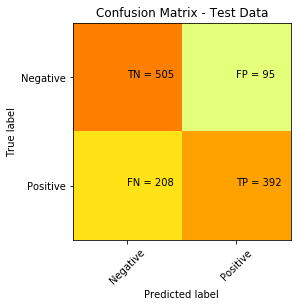

In [0]:
# Displaying the confusion matrix for Random forest model
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test1.argmax(axis=1), y_pred.argmax(axis=1))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
  for j in range(2):
    plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [0]:
len(X_test)
testset.shape

(1200, 3074)

In [0]:
# Displaying classification report for random forest model

from sklearn.metrics import classification_report
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       600
           1       0.80      0.65      0.72       600

   micro avg       0.75      0.75      0.75      1200
   macro avg       0.76      0.75      0.75      1200
weighted avg       0.76      0.75      0.75      1200
 samples avg       0.75      0.75      0.75      1200



In [0]:
y_test.shape

(1200, 1)